In [6]:
import nd2
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
#%matplotlib inline
from skimage import exposure
mpl.rcParams['figure.dpi'] = 300
from cellpose import utils, io, plot, models
from scipy.ndimage import binary_erosion, binary_fill_holes
from matplotlib.gridspec import GridSpec
from scipy.signal import find_peaks
import subprocess
import os
import pandas as pd
from Tusc5ImageUtils import *

import matplotlib.font_manager as fm
if 'Helvetica' not in [f.name for f in fm.fontManager.ttflist]:
    print("Helvetica font is not available. Please make sure Helvetica is installed on your system.")

Helvetica font is not available. Please make sure Helvetica is installed on your system.


In [7]:
### Directory Configuration ###

current_directory = os.getcwd()
print(f"Current Working Directory: {current_directory}")

parent_directory = os.path.dirname(current_directory) # Parent directory
test_stacks_directory = os.path.join(parent_directory, 'Test Stacks')

model_path_dapi = os.path.join(parent_directory, 'ImageAnalysis/cellpose_models/T5_DAPI_V2')
img_path = os.path.join(test_stacks_directory, '2007R_GLUT1_647_WGA_594_0002.nd2')

### Image Insertion ###

f = nd2.ND2File(img_path)
image = f.asarray()

DAPI_stack = to_8bit(image[:,0,:,:].copy())
eGFP_stack = to_8bit(image[:,1,:,:].copy())
WGA_stack = to_8bit(image[:,2,:,:].copy())

mp_DAPI = max_proj(DAPI_stack)
model = models.CellposeModel(pretrained_model=model_path_dapi)
DAPI_masks, flows, styles = model.eval(mp_DAPI, diameter=None, channels=[0,0])

Current Working Directory: d:\Lab Analysis PC\ImageAnalysis


C:\Users\Luis\AppData\Local\Temp\ipykernel_16044\3568453103.py:14: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  f = nd2.ND2File(img_path)


In [8]:
# Dimensions of image
print(f'{round(f.voxel_size().x, 2)} micron per pixel in x')
print(f'{round(f.voxel_size().y, 2)} micron per pixel in y')
print(f'{f.voxel_size().z} micron slice seperation')
print(f'{round(f.voxel_size().x * f.shape[-2],2)} microns by {round(f.voxel_size().y * f.shape[-1],2)} microns')

print(f'Image shape: {f.shape}')

0.12 micron per pixel in x
0.12 micron per pixel in y
0.15 micron slice seperation
125.97 microns by 125.97 microns
Image shape: (102, 4, 1024, 1024)


# Projecting (Flattening) Cells
# Achieving a clean view of veins and axon bundles

In [17]:
z_idxs = nuclei_slices(DAPI_stack, DAPI_masks)
z_avg = int(np.mean(z_idxs))


WGA_projected, WGA_base = cell_projector(WGA_stack, DAPI_masks, z_idxs)

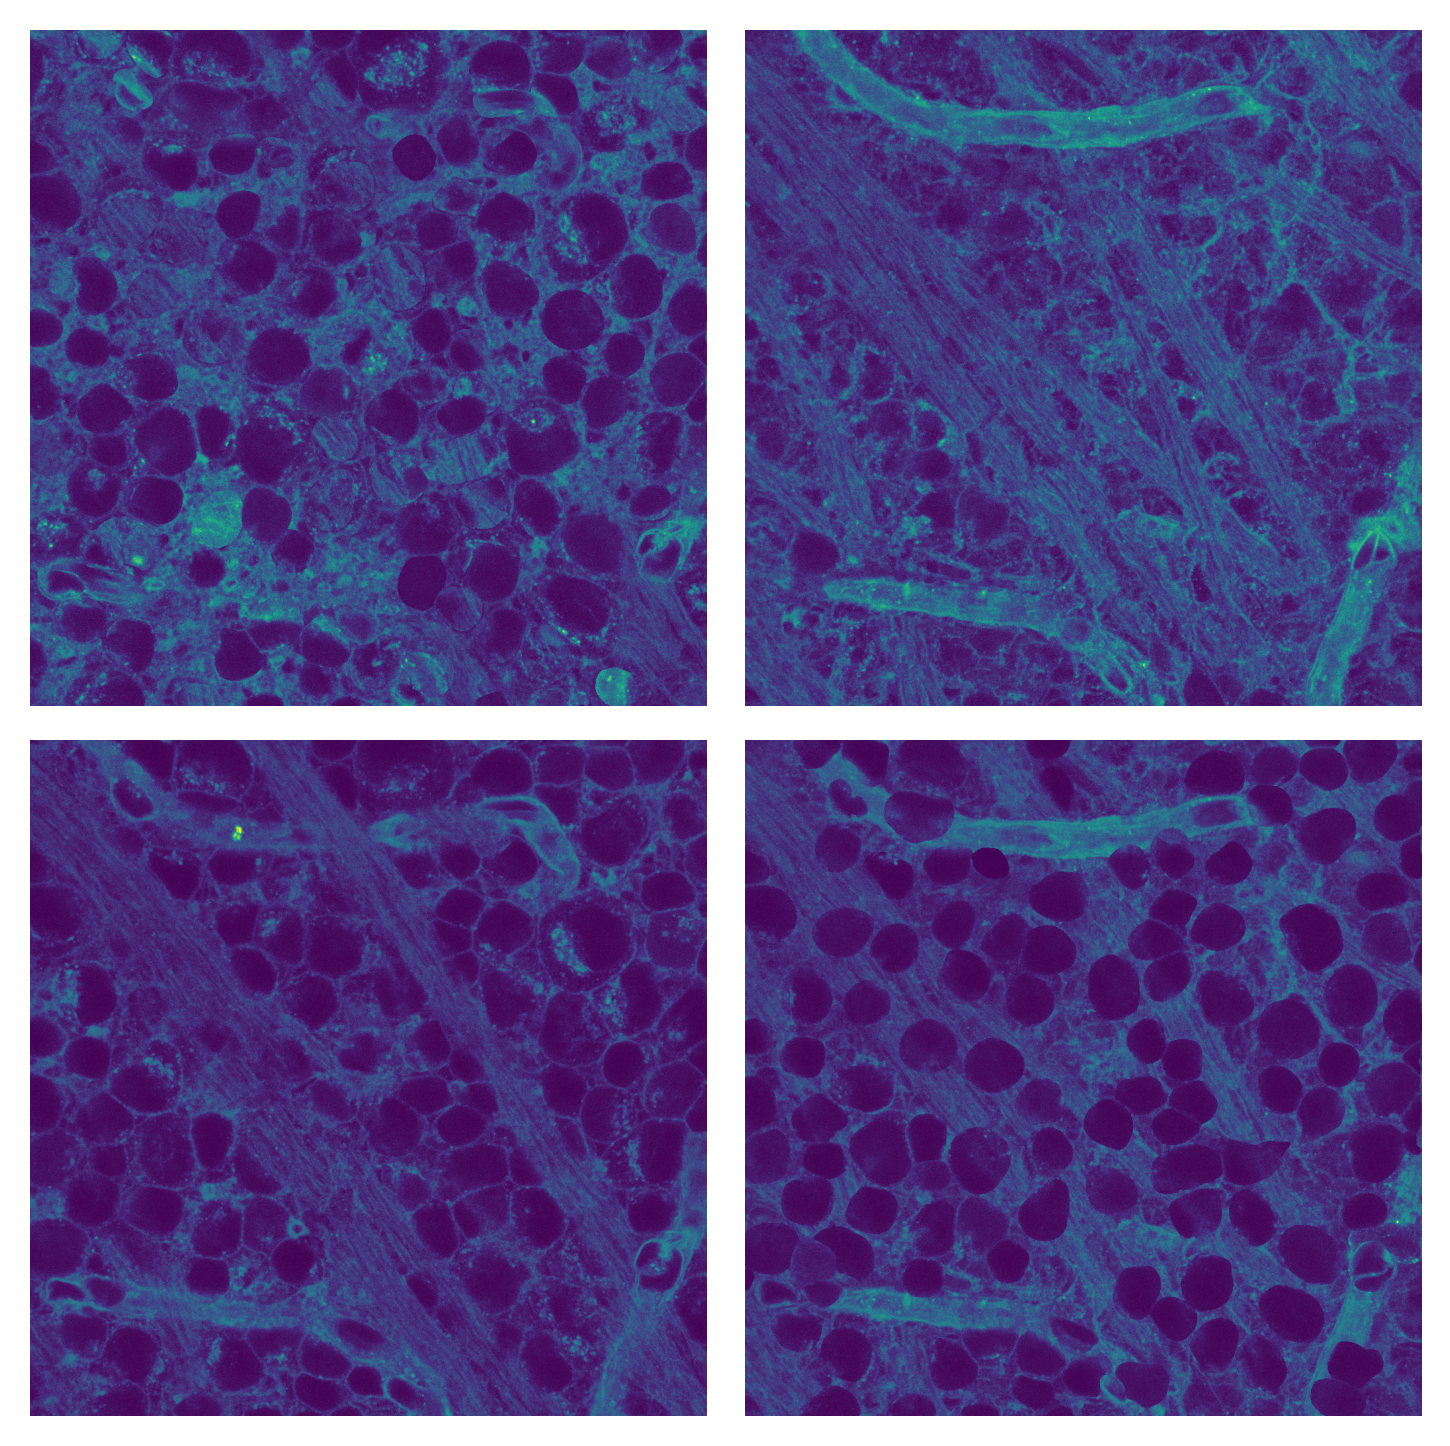

In [21]:
def cell_proj_vein(channel_stack, masks, nuclei_zs):
    '''
    Set up for background image to include veins and axon bundles
    * the slice is chosen as the slice between the ILM and Nuclei layer
    '''
    z_intensities = np.sum(channel_stack, axis=(1, 2))
    
    ILM_layer = int(np.argmax(z_intensities)) / 2
    nuclei_layer = np.sum(nuclei_zs) // len(nuclei_zs)

    vein_axon_layer = int((ILM_layer + nuclei_layer) / 2)

    edited_image = channel_stack[vein_axon_layer, :, :].copy()
    image_background_display = channel_stack[vein_axon_layer, :, :].copy()

    total_masks = np.delete(np.unique(masks, 0), 0)

    '''
    Cell Projection, the center of each cell is brought up
    '''

    # Editing each ROI so we are centered at the middle of each soma
    for mask in total_masks:
        single_mask = masks == mask
        single_slice = nuclei_zs[mask - 1]
        edited_image[single_mask] = channel_stack[single_slice][single_mask]

    return edited_image, image_background_display

vein_after, vein_before = cell_proj_vein(WGA_stack, DAPI_masks, z_idxs)

plot_4images([WGA_base, WGA_projected], [vein_before, vein_after], auto_bc = True)

    
